In [ ]:
import os
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import pickle as p
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, Masking

In [ ]:
file_path = "/content/drive/MyDrive/DLA6/CV_Data01"
classes = ['ba', 'hai','hI', 'ka','ni']
data_split = ['Test', 'Train']

In [ ]:
Y_train = []
X_train = []
X_test = []
Y_test = []

dir_list = os.listdir(file_path)
print(dir_list)
for j in data_split:
    for i in classes:
        for filename in glob.glob(os.path.join(file_path + '/' + i + '/' + j, '*.mfcc')):
            with open(filename, 'r') as f:
                if (j == "Train"):
                    # print(filename)
                    f = open(filename)
                    parsed = f.readlines()
                    parsed = [np.array([float(val) for val in line.split(" ") if val!="\n"]) for line in parsed]
                    X_train.append(np.array(parsed))
                    Y_train.append(str(i))
                if (j == 'Test'):
                    # print(filename)
                    f = open(filename)
                    parsed = f.readlines()
                    parsed = [np.array([float(val) for val in line.split(" ") if val!="\n"]) for line in parsed]
                    X_test.append(np.array(parsed))
                    Y_test.append(str(i))
print("Training Set has {} samples each with dimension {} but variable length".format(len(X_train),X_train[0][0].shape))
print("Test Set has {} samples each with dimension {} but variable length".format(len(X_test),X_test[0][0].shape))

# padding input
max_len = max([len(val) for val in X_train])
print("Max_seq length: ",max_len)
def padd_it(data):
    for i in range(len(data)):
        if len(data[i]) <= max_len:
            seq = np.repeat(np.array([-1]*39).reshape(-1,39),int(max_len-len(data[i])),0)
            data[i] = np.append(data[i],seq,axis=0)
    return data
# data preprocessing steps to prepare the input data for training and testing a model
print("Before Padding shape of first element in train is {}".format((X_train[0]).shape))
X_test = np.asarray(padd_it(X_test))
X_train = np.asarray(padd_it(X_train))
print("After Padding shape of first element in train is {}".format((X_train[0]).shape))

['ni', 'ka', 'hai', 'hI', 'ba']
Training Set has 1570 samples each with dimension (39,) but variable length
Test Set has 393 samples each with dimension (39,) but variable length
Max_seq length:  78
Before Padding shape of first element in train is (16, 39)
After Padding shape of first element in train is (78, 39)


In [ ]:
Y_train=np.array(Y_train).reshape(-1, 1)
Y_test=np.array(Y_test).reshape(-1, 1)

In [ ]:
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
#define ordinal encoding
encoder = OrdinalEncoder()
# transform data
yt= encoder.fit_transform(Y_train)
ytest= encoder.fit_transform(Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 78, 39)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 78, 32)            2304      
                                                                 
 dropout (Dropout)           (None, 78, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 78, 32)            2080      
                                                                 
 dropout_1 (Dropout)         (None, 78, 32)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

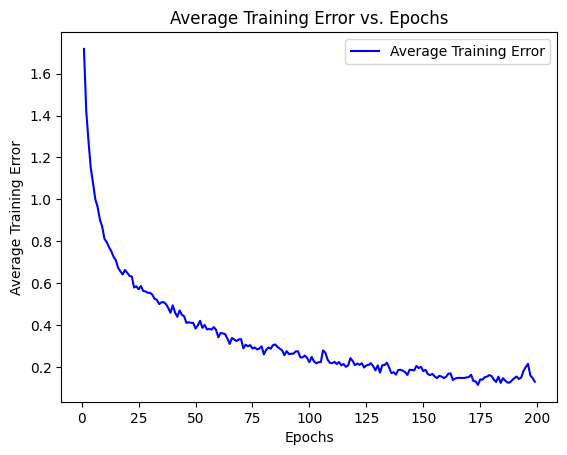

In [ ]:
#Model Architecture 1

CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv125.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 78, 64)            6656      
                                                                 
 dropout_3 (Dropout)         (None, 78, 64)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 78, 64)            8256      
                                                                 
 dropout_4 (Dropout)         (None, 78, 64)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

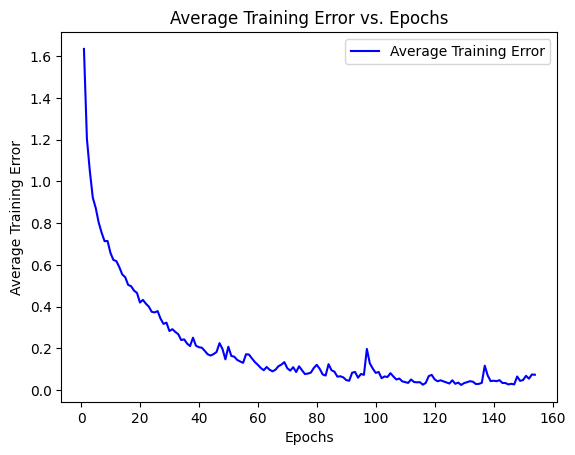

In [ ]:
#Model Architecture 2

CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv225.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 78, 128)           21504     
                                                                 
 dropout_6 (Dropout)         (None, 78, 128)           0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 78, 128)           32896     
                                                                 
 dropout_7 (Dropout)         (None, 78, 128)           0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

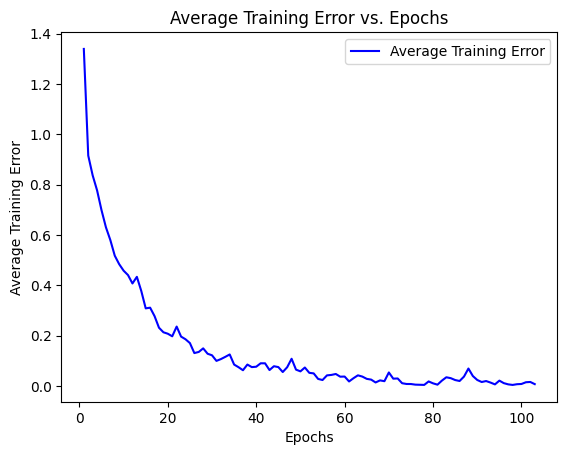

In [ ]:
#Model Architecture 3

CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv325.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





In [ ]:
#ModelArchitecture 1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_9 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 78, 32)            2304      
                                                                 
 dropout_27 (Dropout)        (None, 78, 32)            0         
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 78, 32)            2080      
                                                                 
 dropout_28 (Dropout)        (None, 78, 32)            0         
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dropout_29 (Dropout)        (None, 32)               

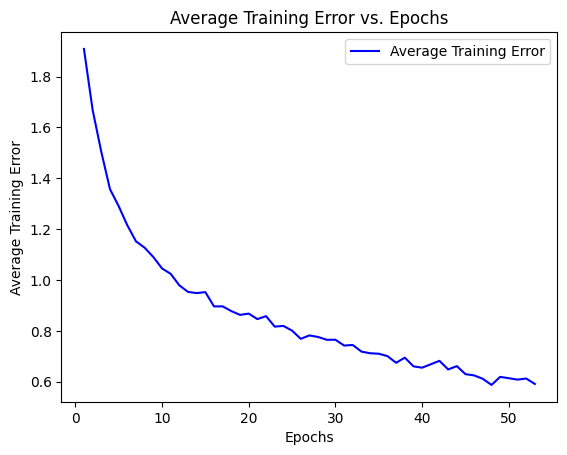

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(32))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv104.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_6 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 78, 32)            2304      
                                                                 
 dropout_18 (Dropout)        (None, 78, 32)            0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 78, 32)            2080      
                                                                 
 dropout_19 (Dropout)        (None, 78, 32)            0         
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dropout_20 (Dropout)        (None, 32)               

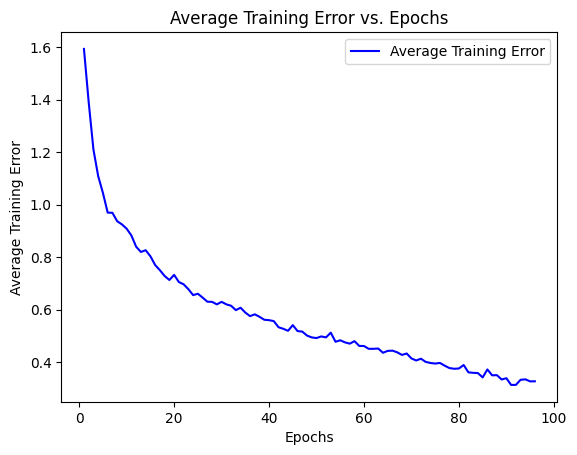

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv1.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 78, 32)            2304      
                                                                 
 dropout_6 (Dropout)         (None, 78, 32)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 78, 32)            2080      
                                                                 
 dropout_7 (Dropout)         (None, 78, 32)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

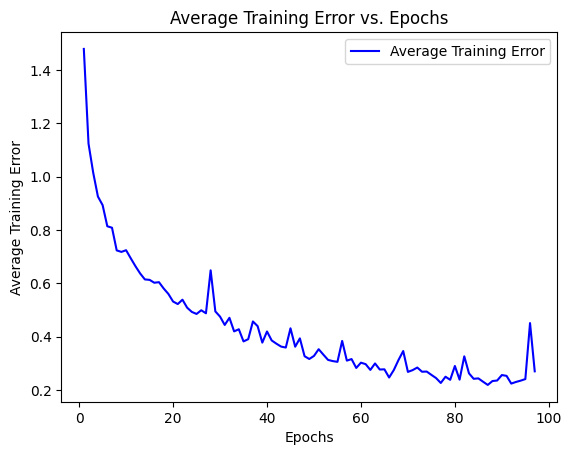

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(32))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=10)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=32,callbacks=[callback] ,epochs=500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv1.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





In [ ]:
#Model Architecture 2

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_10 (Masking)        (None, 78, 39)            0         
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 78, 64)            6656      
                                                                 
 dropout_30 (Dropout)        (None, 78, 64)            0         
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 78, 64)            8256      
                                                                 
 dropout_31 (Dropout)        (None, 78, 64)            0         
                                                                 
 simple_rnn_32 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dropout_32 (Dropout)        (None, 64)              

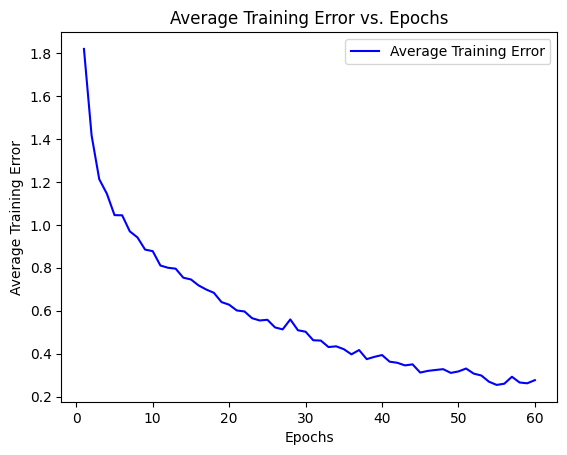

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(64))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv204.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_7 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 78, 64)            6656      
                                                                 
 dropout_21 (Dropout)        (None, 78, 64)            0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 78, 64)            8256      
                                                                 
 dropout_22 (Dropout)        (None, 78, 64)            0         
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)               

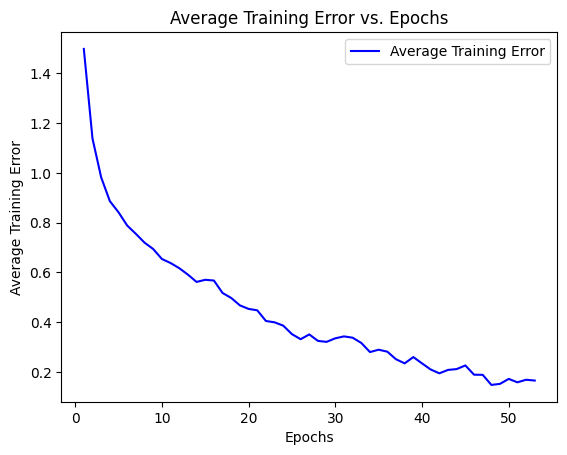

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv2.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 78, 64)            6656      
                                                                 
 dropout_9 (Dropout)         (None, 78, 64)            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 78, 64)            8256      
                                                                 
 dropout_10 (Dropout)        (None, 78, 64)            0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)               

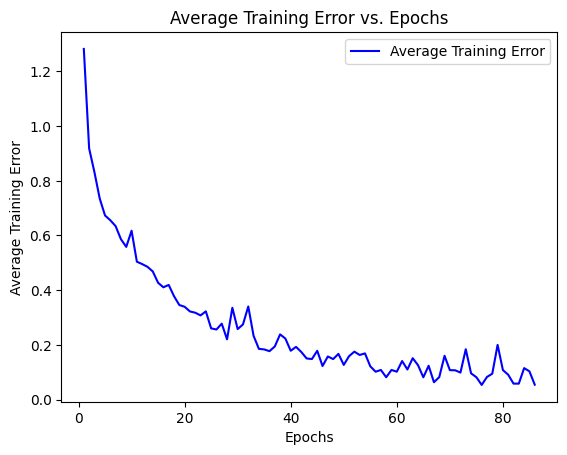

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(64))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=10)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=32,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv2.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





In [ ]:
#Model Architecture 3

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_11 (Masking)        (None, 78, 39)            0         
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 78, 128)           21504     
                                                                 
 dropout_33 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 78, 128)           32896     
                                                                 
 dropout_34 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_35 (Dropout)        (None, 128)             

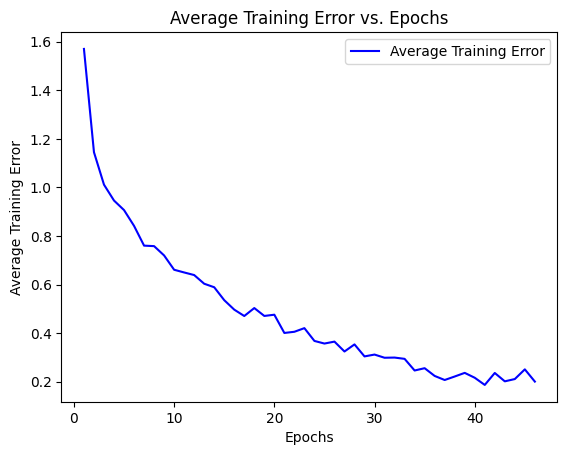

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(SimpleRNN(128))
CV_RNN_Model1.add(Dropout(0.4))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv304.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         (None, 78, 39)            0         
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 78, 128)           21504     
                                                                 
 dropout_24 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 78, 128)           32896     
                                                                 
 dropout_25 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)              

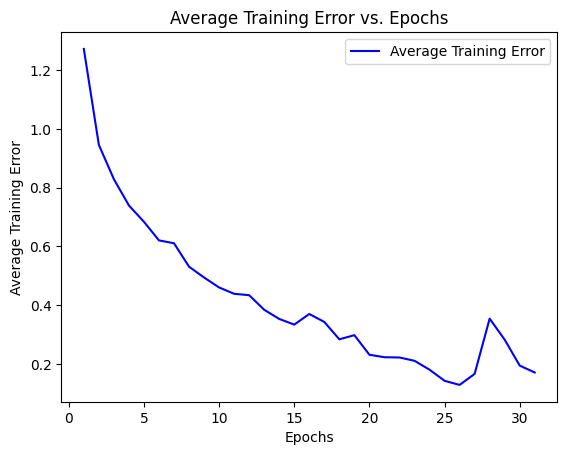

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv3.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_13 (Masking)        (None, 78, 39)            0         
                                                                 
 simple_rnn_39 (SimpleRNN)   (None, 78, 128)           21504     
                                                                 
 dropout_39 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_40 (SimpleRNN)   (None, 78, 128)           32896     
                                                                 
 dropout_40 (Dropout)        (None, 78, 128)           0         
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_41 (Dropout)        (None, 128)             

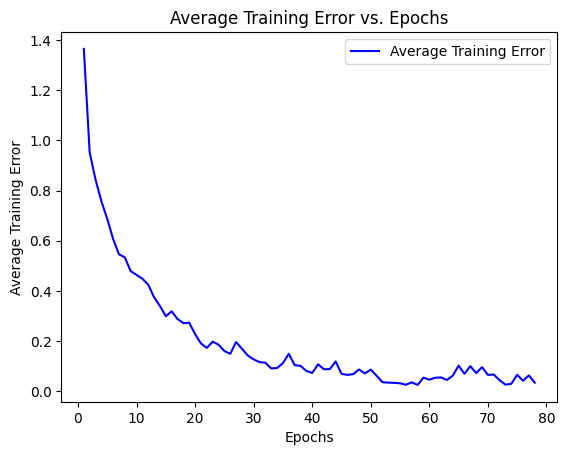

In [ ]:
CV_RNN_Model1=Sequential()
CV_RNN_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128, return_sequences=True))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(SimpleRNN(128))
CV_RNN_Model1.add(Dropout(0.2))
CV_RNN_Model1.add(Dense(5, activation='softmax'))
CV_RNN_Model1.summary()

CV_RNN_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=20)
history = CV_RNN_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_RNN_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv315.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_RNN_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_RNN_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_RNN_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_RNN_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()



